# Modules to be Installed
The following modules are required for this project:
- `os`
- `sys`
- `gmsh`
- `numpy` (`np`)
- `pandas` (`pd`)
- `pyvista` (`pv`)
- `matplotlib.pyplot` (`plt`)
- `math`
- `meshio`
- `gmshparser`
- `importlib`
- `shapely.geometry` (`Polygon`)
- `fortranformat`
- `datetime`
- `collections`
- `warnings`
- `scipy`
- `copy`
- `glob`
- `itertools`
- `functools`
- `time`
- `subprocess`
- `platform`
- `fortranformat`
- `shutil`
```markdown
To install these modules, use the following pip command:

```bash
pip install numpy pandas matplotlib scipy seaborn gmsh pyvista meshio gmshparser shapely fortranformat


```

# Predicting 2 D water and heat fluxes from temperature measurements and differential pressure

We will use `ginette` to predict streambed discharge from temperature measurements in real time. In particular, the class `tempest1d.EKF` provides an extended Kalman filter. Here's an example.

You can find the `ginette` repository on GitHub: [ginette GitHub Repository](https://github.com/agnes-riviere/ginette)

Ginette models temperature by solving a two-dimensional, unsaturated and fully saturated form of the hydrologic energy transport equation [1]. In three dimensions, the equation is

$\frac{d}{dt} \left( \left[\phi {C}_w + \left( 1-\phi \right) {C}_{sed} \right] T \right) = \nabla \cdot \left( \lambda \nabla T \right) - \nabla \cdot \left( \phi {C}_w \vec{v} T \right)$,

where 
$t$ is time in s,
$\phi$ is porosity (a unitless fraction of total volume),
${C}_w$ is the volumetric specific heat capacity of water in J/m$^3$&deg;C,
${C}_{sed}$ is the volumetric specific heat capacity of the dry sediments in J/m$^3$&deg;C,
$T$ is temperature in &deg;C,
$\lambda$ is the thermal conductivity of the porous media in W/m&deg;C (4 models are available to take account ice, water, solid and air),
and $\vec{v}$ is the water velocity in m/s.


## Mass Balance Equation for Pore-Water Pressure

The mass balance equation used to calculate the pore-water pressure in the ($x$,$z$) plane is written:

$\frac{\partial}{\partial{x}} \left(\frac{\rho_w k k_r(T)}{\mu} \left(\frac{\partial{p}}{\partial{x}}\right)\right) + \frac{\partial}{\partial{z}} \left(\frac{\rho_w k k_r(T)}{\mu} \left(\frac{\partial{p}}{\partial{z}}+\rho_w g\right)\right) = \frac{S_{k}}{g} \frac{\partial{p}}{\partial{t}}  $

where 
- $t$ is time (s),
- $p$ is the pressure (Pa),
- $k$ is the intrinsic permeability ($m^{2}$),
- $k_{r}$(T,Sat) is the relative permeability,
- $g$ is the acceleration due to gravity (m\,$s^{-2}$),
- $\mu$ is the dynamic viscosity of water (Pa\,s),
- $\rho_{w}$ is the density of water (kg\,$m^{-3}$),
- $S_{k}$ is the specific storage coefficient ($m^{-1}$, see below).

The specific storage coefficient for fully saturated cells  is the specific storage coefficient $S_{s}$ in case of confined aquifer.

$S_{k}=S_{s}= \rho_{w} \, g \, n \, \left(\beta_f-\beta_s + \frac{\alpha_{c}}{ n }\right)$ , 

where 
- $n$ is the total porosity,
- $\beta_f$ is the compressibility of water ($Pa^{-1}$),
- $\beta_s$ is the compressibility of the solid rock grains ($Pa^{-1}$),
- $\alpha_c$ is the compressibility coefficient of the porous medium ($Pa^{-1}$).

For the unconfined aquifer, the specific storage coefficient is written:

$
S_{k}=\frac{n_{d}}{e \, s_{w}},
$

with 
- $n_{d}$ the drainable porosity,
- $e$ the thickness of the grid cell (m),
- $s_{w}$ the saturation of  water.
  
The Richards equation is also implemented but we won"t use it.




In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Oct 18 14:57:23 2023
"""
dir_ginette = '/home/ariviere/Programmes/ginette'
import sys
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
import math
import fortranformat as ft
import glob
import time
from collections import namedtuple
from dataclasses import dataclass
from random import uniform, gauss
from numpy import inf, nansum, log, size, var, mean, isclose, sqrt, zeros, all
from itertools import product
from typing import Callable, Tuple, Sequence
from pathlib import Path
from scipy.interpolate import interp1d, griddata
from matplotlib.colors import LogNorm
import matplotlib.dates as mdates
import pyvista as pv
import shutil
# Ajouter le chemin du dossier src au PYTHONPATH
import importlib

sys.path.append(dir_ginette)  # Ajouter le dossier parent de src
# use __init__.py to import all functions/ in src/src_gmsh and src/src_pythont
# insure 
from src.src_gmsh import mesh_generator
from src.src_python import Init_folders
from src.src_python import Direct_model
from src.src_python import Read_obs
from src.src_python import Plot
from src.src_python import stat_critere

# Import all functions/classes from the relevant modules
from src.src_gmsh import mesh_generator
from src.src_gmsh.mesh_generator import *
from src.src_python.Init_folders import *
from src.src_python.Direct_model import *
from src.src_python.Read_obs import *
from src.src_python.Plot import *
from src.src_python.stat_critere import *
import importlib
importlib.reload(mesh_generator)
importlib.reload(Read_obs)
importlib.reload(Plot)
importlib.reload(Init_folders)
importlib.reload(Direct_model)
importlib.reload(mesh_generator)
importlib.reload(stat_critere)
# Ajouter le chemin du dossier src au PYTHONPATH
src_dir=os.path.join(dir_ginette, "src")
sys.path.insert(0, src_dir)
# give me all names of the functions in Init_folders
#print(Init_folders.__dict__)
#print([name for name in dir(Init_folders) if callable(getattr(Init_folders, name)) and not name.startswith("__")])

compile_ginette()

/home/ariviere/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


ginette exists


In [2]:
# Configuration du répertoire de travail
# Utiliser os.getcwd() pour obtenir le répertoire de travail actuel
script_dir = os.getcwd()  # Répertoire du notebook
mesh_dir = os.path.join(script_dir, "meshdata")  # Chemin absolu vers "meshdata"
sim_dir= script_dir
desc_dir = "/home/ariviere/Documents/Bassin_Orgeval/Donnee_Orgeval_Mines/raw_data/DESC_data/DATA_STATION/"  # Chemin vers le fichier CSV
obs_dir=os.path.abspath(os.path.join(desc_dir, "../../../processed_data/"))

# Paramètres de du maillage
## name de la station
Station = "IntB"
# Paramètres sens de la station par rapport à la direction de la rivière
#       |   ↑    |
#  RG   |   ↑    |  RD
#       |        |
#  Rive_D=0 station à l'envers x_piezo_RD=0m dans l'exemple du schema
Rive_D=0
plot=True
meshplot=True
altitude_min = 110.775
dz_pt100=0.10
dz_pt100first=0.1
dt=900
date_simul_bg = pd.to_datetime("2013/09/19 12:00:00")
nb_day = 30
desc_station = {'RD': 'pzps7', 'RG': "pzps7", 'RIV': "rivsma"}
# Call the function to get the river mesh indices identifiant mesh cell
xRG=4.2
xRD=7.9
# Zone parameters
parameters=['k', 'n', 'l', 'cs', 'r']
nb_zone=4

start_date 2013-09-19 12:00:00
end_date 2013-10-19 12:00:00
Capteurs charges : ['pzps7', 'Hobo5', 'rivsma']
Nombre de donnees pour pzps7 : 2881
Nombre de donnees pour rivsma : 2881
Nombre de donnees pour Hobo5 : Temp_Hobo5_C1    2881
Temp_Hobo5_C2    2881
Temp_Hobo5_C3    2881
Temp_Hobo5_C4       0
dtype: int64


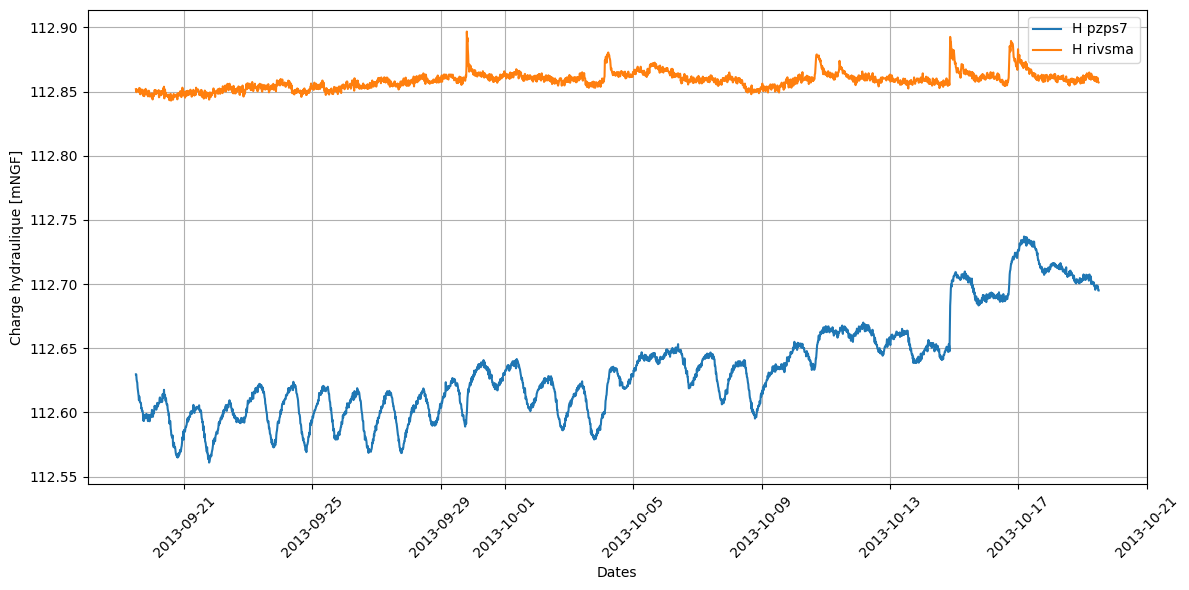

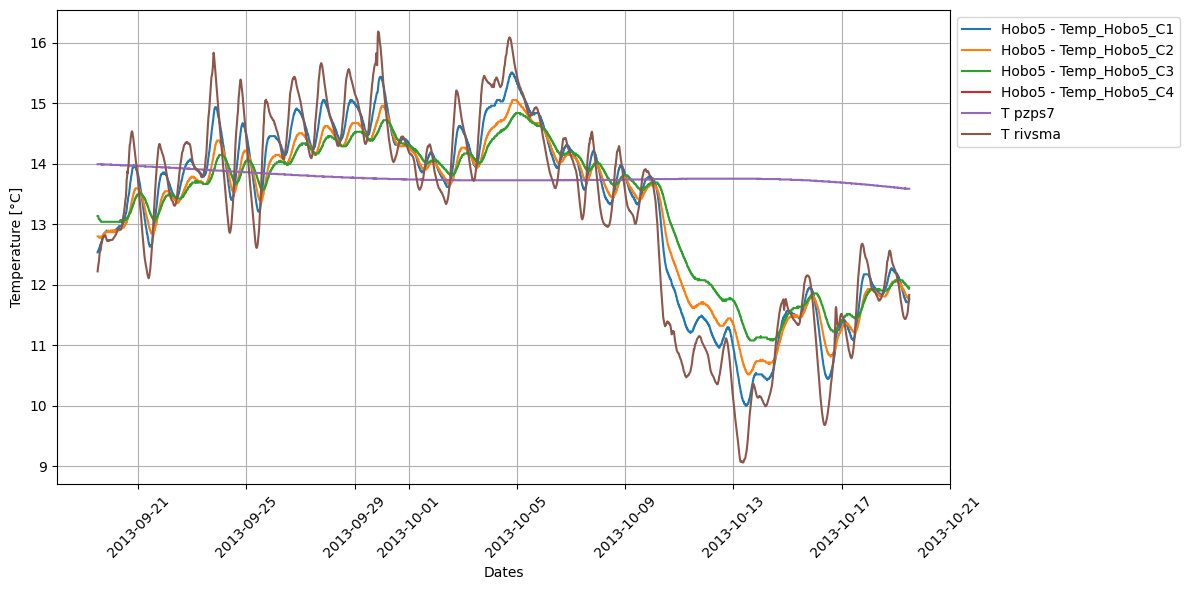

In [3]:
from src.src_python.Plot import plot_obs_station
start_date = pd.to_datetime(date_simul_bg)
end_date = start_date + pd.Timedelta(days=nb_day)
print("start_date",start_date)
print("end_date",end_date)
plot_obs_station(Station,obs_dir,start_date=start_date,end_date=end_date)

# zone of hydrofacies

Chemin du fichier de nivellement CSV : /home/ariviere/Documents/Bassin_Orgeval/Donnee_Orgeval_Mines/raw_data/DESC_data/DATA_STATION/IntB/IntB.csv


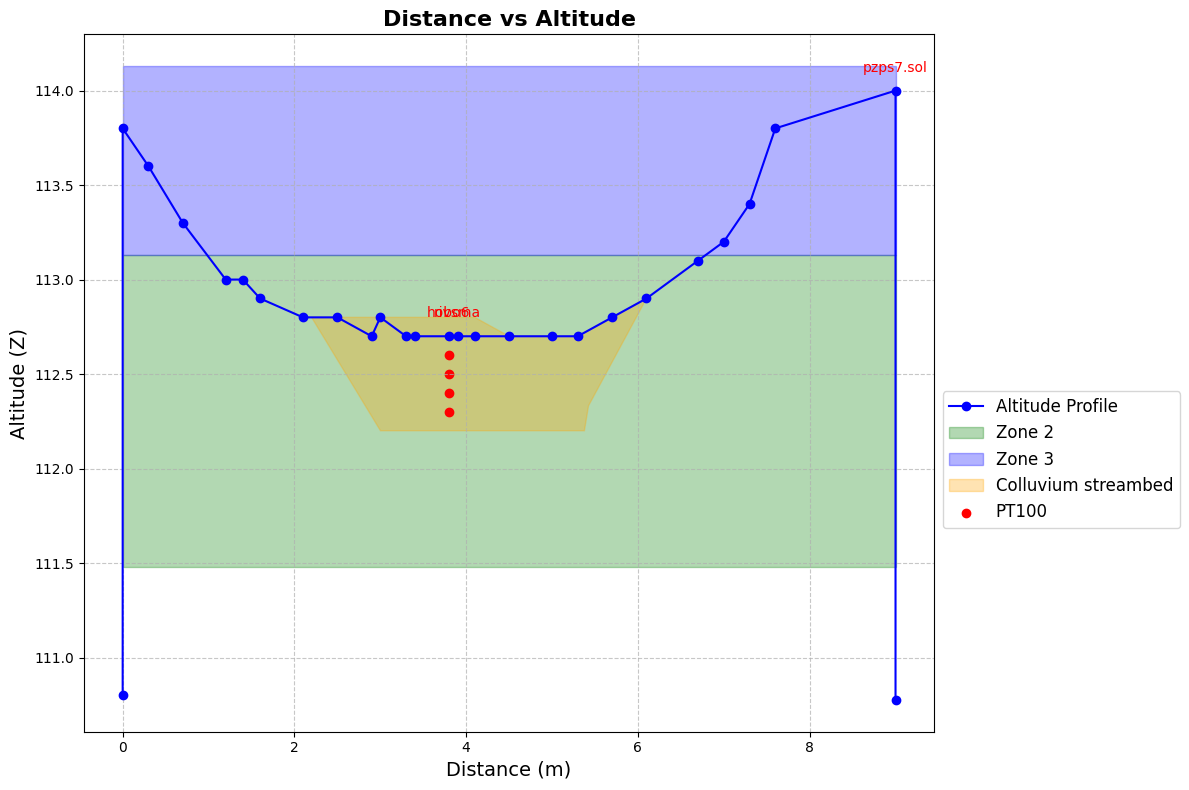

In [4]:
# reading the data georef
distance_altitude_table,pt100_coord= process_distance_altitude(desc_dir, Station, mesh_dir, altitude_min, Rive_D,dz_pt100=dz_pt100,dz_pt100first=dz_pt100first)    


# definition des zones zones
#zone 1  Green clays
# zone 2  Millstone block  xmin=-1 zmin=-3.8 xmax=10 ymin=1
rect_2 = np.array([
    [0, 113.13],
    [9, 113.13],
    [9, 111.48],
    [0, 111.48]
])
# limon loam
rect_3 = np.array([
    [0, 114.13], 
    [9, 114.13],
    [9,113.13],
    [0, 113.13]])

# zone 4  zh streambed colluvial
poly_4= np.array([
    [6.1, 112.9],
    [5.7,112.8],
    [5.3,112.7],
    [5., 112.7],
    [4.7, 112.7],
    [4.3, 112.7],
    [4, 112.7],
    [4.6, 112.7],
    [4.5, 112.7],
    [4.1, 112.8],
    [2.7, 112.8],
    [2.2, 112.8],
    [3.00214, 112.2],
    [3.46789, 112.2],
    [5.37692, 112.2],
    [5.42475, 112.33166]
])

# 
#    
# plot des données
if plot:
    

    # Configure the plot
    plt.figure(figsize=(12, 8))
    plt.plot(
        distance_altitude_table["Distance (m)"],
        distance_altitude_table["Altitude (Z)"],
        marker='o',
        # add name distance_altitude_table["Instrument"] if not NA
        linestyle='-',
        color='blue',
        label='Altitude Profile'
    )

    # Ajouter les noms des instruments au-dessus des points si ce n'est pas "NA"
    for i, instrument in enumerate(distance_altitude_table["Instrument"]):
        if instrument != "NA" and not pd.isna(instrument):
            plt.text(
                distance_altitude_table["Distance (m)"][i],
                distance_altitude_table["Altitude (Z)"][i] + 0.1,  # Décalage vertical pour éviter de chevaucher le point
                instrument,
                fontsize=10,
                color='red',
                ha='center'
            )
    # Tracer les zones rectangulaires xmin ymin and xmax ymax

    plt.fill(rect_2[:, 0], rect_2[:, 1], color='green', alpha=0.3, label='Zone 2')
    plt.fill(rect_3[:, 0], rect_3[:, 1], color='blue', alpha=0.3, label='Zone 3')
    plt.fill(poly_4[:, 0], poly_4[:, 1], color='orange', alpha=0.3, label='Colluvium streambed')



# Tracer les capteurs de température PT100
    if not pt100_coord.empty:
        pt100_label_added = False  # Variable pour suivre si le label "PT100" a été ajouté
        for i in range(len(pt100_coord)):
            plt.scatter(
                pt100_coord["Distance (m)"][i],
                pt100_coord["Altitude (Z)"][i],
                color='red',
                label="PT100" if not pt100_label_added else None  # Ajouter le label uniquement une fois
            )
            pt100_label_added = True  # Marquer que le label a été ajouté
    # Add titles and labels    # Initialize the neighbors as -99 (no neighbor)
    # The neighbors are stored in the ivois DataFrame
    plt.title("Distance vs Altitude", fontsize=16, fontweight='bold')
    plt.xlabel("Distance (m)", fontsize=14)
    plt.ylabel("Altitude (Z)", fontsize=14)

    # Add grid and legend
    plt.grid(True, linestyle='--', alpha=0.7)
 # Ajouter la légende en dehors de la figure, à droite
    plt.legend(fontsize=12, loc='upper left', bbox_to_anchor=(1, 0.5))

    # Show the plot
    plt.tight_layout()
    plt.show()
#     





In [5]:
pt100_coord

,hobo,pt100,Distance (m),Altitude (Z)
0,hobo6,1,3.8,112.6
1,hobo6,2,3.8,112.5
2,hobo6,3,3.8,112.4
3,hobo6,4,3.8,112.3


# Read the observation data

This section focuses on reading and processing the observation data for the simulation. The data includes temperature and hydraulic head measurements from various sensors (e.g., PT100, Hobo) located at different positions in the domain. The processed data will be used as input for the simulation and validation of the model.


In [6]:

all_data, hmax,hmin,hqt95=process_obs_RIV2D(Station, obs_dir, date_simul_bg, nb_day, desc_station, pt100_coord)


Start date: 2013-09-19 12:00:00 End date: 2013-10-19 12:00:00
Processing sensor type: pzps7
Processing sensor type: Hobo5


/home/ariviere/Programmes/ginette/src/src_python/Read_obs.py:124: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_column] = pd.to_datetime(df[date_column], errors='raise')


Processing sensor type: rivsma


/home/ariviere/Programmes/ginette/src/src_python/Read_obs.py:124: UserWarning: Parsing dates in %d/%m/%Y %H:%M format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[date_column] = pd.to_datetime(df[date_column], errors='raise')


In [7]:
pt100_coord

,hobo,pt100,Distance (m),Altitude (Z),index
0,hobo6,1,3.8,112.6,1
1,hobo6,2,3.8,112.5,2
2,hobo6,3,3.8,112.4,3
3,hobo6,4,3.8,112.3,4


# Build the model
## Build the mesh

The mesh is constructed with a rectangular domain, ensuring a structured grid for the simulation. The domain is divided into regions with varying resolutions to capture the necessary details for the model.

In [8]:

## altitude min du maillage
x_hoboRG = None
x_hoboRD = 3.8
z_hoboRG = None
z_hoboRD = 112.7
x_RG = 3.025
x_RD = 4.575

### z_riv and v_bot represent the z-coordinates for the river surface and the bottom of the river, respectively.
z_riv=112.7125
v_bot=112.2625
dx_precis = 0.25
dx_grossier = 0.5
dz_grossier = 0.5
dz_precis = 0.025
dx_hobo = 0.05


# Filter out None values before using max
z_candidates = [z for z in [z_riv, z_hoboRG, z_hoboRD] if z is not None]
z_start = max(z_candidates)
# Calculate number of divisions
length= z_start - v_bot
print('length', round(length, 4),length)
n_div_riverbed = int(round(length, 4)/ dz_precis)+1

print("n_div_riverbed", n_div_riverbed)

# Use linspace to generate the correct number of points (descending)
z_est = np.linspace(z_start , v_bot, n_div_riverbed)
print(z_est)



length 0.45 0.45000000000000284
n_div_riverbed 19
[112.7125 112.6875 112.6625 112.6375 112.6125 112.5875 112.5625 112.5375
 112.5125 112.4875 112.4625 112.4375 112.4125 112.3875 112.3625 112.3375
 112.3125 112.2875 112.2625]


## verification à lire!!!

In [9]:
 # Calcul des subdivisions en x pour les regions centre 2 et 5
length_x_centre = x_RD-x_RG
num_div_x_centre = max(2, math.ceil(length_x_centre / dx_precis))
max_x=distance_altitude_table['Distance (m)'].max()
min_x=distance_altitude_table['Distance (m)'].min()
max_z=distance_altitude_table['Altitude (Z)'].max()
min_z=distance_altitude_table['Altitude (Z)'].min()
# Calcul des subdivisions en x pour les regions de gauche 1, 4 et 7
# Update z_riv to be the maximum of input z_riv and HOBO heights
if z_hoboRG is None and z_hoboRD is not None:
    z_hoboRG, z_hoboRD = z_hoboRD, z_hoboRG
    x_hoboRG, x_hoboRD = x_hoboRD, x_hoboRG
    if not (min_x < x_RG<x_hoboRG < x_RD < max_x):
        raise ValueError(f"Invalid x coordinates: min_x={min_x}, x_RG={x_RG}, x_hoboRG={x_hoboRG}, x_RD={x_RD}, max_x={max_x}")
        print("Only one temperature profile exist")

if z_hoboRG is not None and z_hoboRD is not None:
    if not (min_x < x_RG<x_hoboRG<x_hoboRD < x_RD < max_x):
        raise ValueError(f"Invalid x coordinates: min_x={min_x}, x_RG={x_RG}, x_hoboRG={x_hoboRG}, x_hoboRD={x_hoboRD}, x_RD={x_RD}, max_x={max_x}")
        print("Only one temperature profile exist")
        print("Two temperature profile exist")
if z_hoboRG is not None and z_hoboRD is None:
        z_riv = max(z_hoboRG, z_riv)
        print("Only one temperature profile exist")

        
        # Calculate basic subdivisions
length_x_gauche = round(abs(x_RG - min_x),4)
length_x_droite = round(abs(max_x - x_RD),4)
length_x_centre = round(abs(x_RD - x_RG),4)

        
num_div_x_gauche = calculate_subdivisions(length_x_gauche, dx_grossier)
num_div_x_centre = calculate_subdivisions(length_x_centre, dx_precis)
num_div_x_droite = calculate_subdivisions(length_x_droite, dx_grossier)
      
num_div_z_haut = calculate_subdivisions(abs(round(max_z - z_riv,4)), dz_grossier)
num_div_z_centre = calculate_subdivisions(abs(round(z_riv - v_bot,4)), dz_precis)
num_div_z_bas = calculate_subdivisions(abs(round(v_bot - min_z,4)), dz_grossier)
# assurer que `min_x < x_RG < x_RD < max_x`  `min_z < v_bot < z_riv < max_z`
if not (min_x < x_RG < x_RD < max_x):
    raise ValueError(f"Invalid x coordinates: min_x={min_x}, x_RG={x_RG}, x_RD={x_RD}, max_x={max_x}")
if not (min_z < v_bot < z_riv < max_z):
    raise ValueError(f"Invalid z coordinates: min_z={min_z}, v_bot={v_bot}, z_riv={z_riv}, max_z={max_z}")

if min(length_x_gauche, length_x_centre, length_x_droite) <= 0:
      raise ValueError("Erreur : une des longueurs en x est nulle ou négative.")
if min(num_div_x_gauche, num_div_x_centre, num_div_x_droite,num_div_z_haut, num_div_z_centre, num_div_z_bas) < 2:
    raise ValueError("Erreur : une des subdivisions est < 2.")

print(f"Subdivisions calculées :\n"
            f"  - Gauche : {num_div_x_gauche} subdivisions\n"
            f" - dx gauche : {length_x_gauche / num_div_x_gauche:.4f} m\n"
            f"  - Centre : {num_div_x_centre} subdivisions\n"
            f" - dx centre : {length_x_centre / num_div_x_centre:.4f} m\n"
            f"  - Droite : {num_div_x_droite} subdivisions\n"
            f" - dx droite : {length_x_droite / num_div_x_droite:.4f} m\n"
            f"  - Haut : {num_div_z_haut} subdivisions\n"
            f" - dz haut : {(max_z - z_riv) / num_div_z_haut:.4f} m\n"
            f"  - Centre : {num_div_z_centre} subdivisions\n"
            f" - dz centre : {(z_riv - v_bot) / num_div_z_centre:.4f} m\n"
            f"  - Bas : {num_div_z_bas} subdivisions\n"
            f" - dz bas : {(v_bot - altitude_min) / num_div_z_bas:.4f} m\n")

Only one temperature profile exist
Subdivisions calculées :
  - Gauche : 7 subdivisions
 - dx gauche : 0.4321 m
  - Centre : 7 subdivisions
 - dx centre : 0.2214 m
  - Droite : 10 subdivisions
 - dx droite : 0.4425 m
  - Haut : 4 subdivisions
 - dz haut : 0.3219 m
  - Centre : 19 subdivisions
 - dz centre : 0.0237 m
  - Bas : 4 subdivisions
 - dz bas : 0.3719 m



In [10]:
from src.src_gmsh import mesh_generator
from src.src_gmsh.mesh_generator import *
importlib.reload(mesh_generator)
if meshplot:
    # Appel de la fonction
    output_mesh_path = os.path.join(mesh_dir, "rectangular_mesh.msh")
    generate_mesh_8_region_optimized(distance_altitude_table, output_mesh_path,v_bot=v_bot,x_RG =x_RG, x_RD = x_RD,z_riv=z_riv, 
                           dx_grossier=dx_grossier, dx_precis = dx_precis,x_hobo_1 =x_hoboRG, z_hobo_1=z_hoboRG,x_hobo_2 = None,z_hobo_2=None, dx_hobo=dx_hobo, 
                           dz_grossier=dz_grossier, dz_precis=dz_precis,dz_hobo1=dz_pt100first,dz_hobo=dz_pt100,mesh_dimension=2)

    output_mesh_path = os.path.join(mesh_dir, "rectangular_mesh.msh")
    remove_elements_above_curve_all_entities(distance_altitude_table, output_mesh_path, ajout='_remove_all_entities', retirer='')
    plot_gmsh_mesh(output_mesh_path.replace(".msh", "_remove_all_entities.msh")) # Modification du nom car on applique 2 fois la fct remove elements 




=== Generating optimized structured mesh with GMSH ===
Domain: X=[0.0000, 9.0000], Z=[110.7750, 114.0000]
River level: 112.7125, Riverbed Bottom level: 112.2625
num_div_z_centre 19 dz_precis 0.025
ici 0.45
num_div_z_centre 19 dz_precis 0.025 dz_calcul 0.0237
dx_reel 0.22142857142857147 0.05
hobo_params {'num_div_x_hobo': 5, 'num_div_x_RG_hobo': 3, 'num_div_x_hobo1_hobo2': 4, 'num_div_x_hobo2_RD': None, 'num_div_x_hobo2': None, 'x_gauche_hobo': 3.689285714285714, 'x_droite_hobo': 3.9107142857142856, 'x_gauche_hobo2': None, 'x_droite_hobo2': None}
Subdivisions - Left: 7, Center: 7, Right: 10
Z subdivisions - Top: 4, Center: 19, Bottom: 4
Regions with one temperature profile
Creating 12 mesh regions...
All lines are defined and in correct order.
p1_tag: 1, p2_tag: 2
Point 1 coordinates: x=0.0, y=0, z=112.2625
Point 2 coordinates: x=3.025, y=0, z=112.2625
Adding line between points <src.src_gmsh.mesh_generator.MeshPoint object at 0x7e71d7db86d0> and <src.src_gmsh.mesh_generator.MeshPoint 

Widget(value='<iframe src="http://localhost:33685/index.html?ui=P_0x7e71d7d74d90_0&reconnect=auto" class="pyvi…

## Creation of the Coordinate File

This section focuses on generating the coordinate file for the mesh. The file contains the x and z coordinates of the mesh centers, which are essential for defining the spatial structure of the simulation domain. The coordinates are extracted from the mesh data and saved in a format compatible with the simulation software.

In [11]:

from src.src_gmsh import mesh_generator
importlib.reload(mesh_generator)

from src.src_gmsh.mesh_generator import readGmsh
fName = os.path.join(mesh_dir, "rectangular_mesh_remove_all_entities.msh")
# rename to pt100_coord with x and z
pt100_coord.rename(columns={"Distance (m)": "x", "Altitude (Z)": "z"}, inplace=True)

centres,nb_mesh,def_maille = readGmsh(fName, precision=3)
# write the coordinates in a file witout the header
centres.to_csv(os.path.join(sim_dir, "E_coordonnee.dat"), sep=' ', header=False, index=False)
def_maille.to_csv(os.path.join(sim_dir, "E_def_maille.dat"), sep=' ', header=False, index=False)

# write index with the first =1 in the first column of the centres dataframe
centres['index'] = np.arange(1, len(centres) + 1)




### Plot the Center of Cells

This section visualizes the center of each mesh cell in the domain. The plot provides a clear representation of the spatial distribution of the mesh centers, which is essential for understanding the structure of the simulation grid.

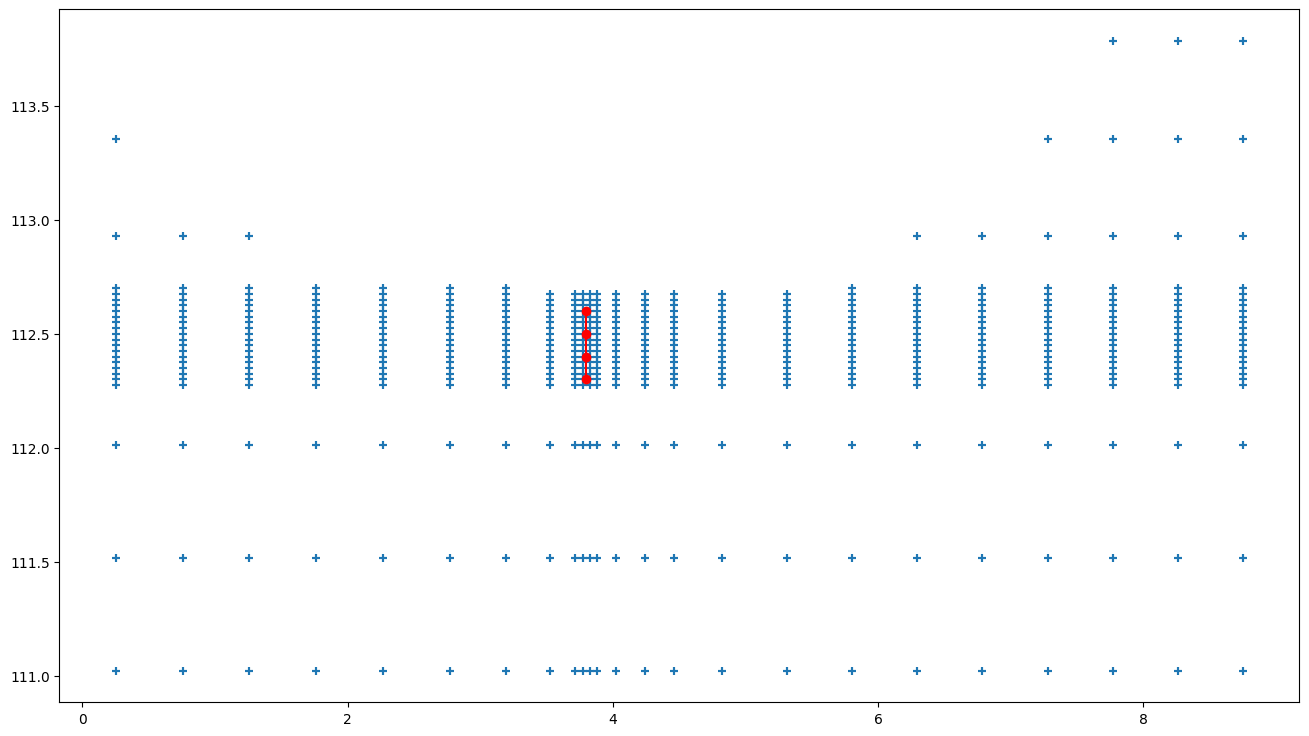

In [12]:
# interactive corrdinates on the plot
x = centres['x']
z = centres['z']
fig, ax = plt.subplots(figsize = (16,9))
# add pt100_coord to the plot
ax.plot(pt100_coord['x'], pt100_coord['z'], marker='o', linestyle='-', color='red', label='PT100') 
ax.scatter(x,z,marker="+") # Trace le centre de chaque mailles
plt.show()

## Index of the Temperature Sensors
The index corresponds to Ginette's `n_maille` values, which are saved for each temperature sensor.

In [13]:
# Find the index of the mesh center nearest to each PT100 coordinate and add the corresponding information to pt100_coord
for i in range(len(pt100_coord)):
    # Calculate the index of the nearest mesh center to the current PT100 coordinate
    index = ((centres['x'] - pt100_coord["x"][i])**2 + (centres['z'] - pt100_coord["z"][i])**2).idxmin()
    
    # Add the index of the nearest mesh center to the pt100_coord DataFrame
    pt100_coord.loc[i, 'index'] = centres.loc[index, 'index']
    
    # Calculate and add the distance between the PT100 coordinate and the nearest mesh center
    pt100_coord.loc[i, 'distance'] = np.sqrt((centres['x'][index] - pt100_coord["x"][i])**2 + (centres['z'][index] - pt100_coord["z"][i])**2)
    
    # Add the x and z coordinates of the nearest mesh center to the pt100_coord DataFrame
    pt100_coord.loc[i, 'xmaille'] = centres.loc[index, 'x']
    pt100_coord.loc[i, 'zmaille'] = centres.loc[index, 'z']

# Convert the 'index' column to integers and store it in a new column 'n_maille'
pt100_coord['n_maille'] = pt100_coord['index'].astype(int)

# Display the first 8 rows of the updated pt100_coord DataFrame
print(pt100_coord.head(8))

    hobo  pt100    x      z  index  distance  xmaille  zmaille  n_maille
0  hobo6      1  3.8  112.6    389     0.028    3.772    112.6       389
1  hobo6      2  3.8  112.5    397     0.028    3.772    112.5       397
2  hobo6      3  3.8  112.4    405     0.028    3.772    112.4       405
3  hobo6      4  3.8  112.3    413     0.028    3.772    112.3       413


### Plot the Figure for Verification

This section visualizes the mesh centers and their indices to verify the spatial structure of the simulation grid. The plot provides a clear representation of the mesh layout, helping to ensure that the mesh is correctly defined and aligned with the simulation requirements.

In [ ]:

# Filter to zoom in on the desired region
centres_zoom = centres[
    (centres['x'] > 6.6) & (centres['x'] < 7) &
    (centres['z'] > 112.) & (centres['z'] < 114.6)
]

# Plot the points
plt.figure(figsize=(12, 8))
plt.scatter(centres_zoom['x'], centres_zoom['z'], c=centres_zoom['index'], cmap='viridis', s=30)

# Add text labels for each point
for _, row in centres_zoom.iterrows():
    plt.text(row['x'], row['z'], str(row['z']), fontsize=20, color='black', ha='center', va='center')

# Add axis labels and a colorbar for clarity
plt.xlabel('x (meters)')
plt.ylabel('z (meters)')
plt.title('Zoom on Mesh Centres with Index Numbers')
plt.colorbar(label='Mesh Number')
plt.show()

## Creation of Dimensions
- `nb_col`: Number of columns in the mesh grid.
- `nb_row`: Number of rows in the mesh grid.

Create the files `E_colonne.dat` and `E_row.dat` to store the column and row indices of the mesh grid.

In [ ]:
# Call the function to calculate the number of columns and rows in the mesh grid
# This function reads the mesh data and determines the grid dimensions
nb_col, nb_row = coord_to_row_column(script_dir)

## Build the Neighbor Table
### and the Index of the Cell at the Right and Left Side of the Simulated Domain
- **col1**: Index of the right neighbor cell.
- **col2**: Index of the left neighbor cell.
- **col3**: Index of the top neighbor cell.
- **col4**: Index of the bottom neighbor cell.

In [ ]:
ivois = voisin_mesh(script_dir)
RG, RD = maille_limite(script_dir)

### Plot to check the index

In [ ]:


# Filter to zoom in on the desired region
centres_zoom = centres[
    (centres['x'] > 4.6) & (centres['x'] < 12.4) &
    (centres['z'] > 112) & (centres['z'] < 114)
]

# Plot the points
plt.figure(figsize=(12, 8))
plt.scatter(centres_zoom['x'], centres_zoom['z'], c=centres_zoom['index'], cmap='viridis', s=30)

# Add text labels for each point with rotated text
for _, row in centres_zoom.iterrows():
    plt.text(row['x'], row['z'], str(row['index']), fontsize=10, color='black', ha='center', va='top', 
             rotation=90)



# Add axis labels and a colorbar for clarity
plt.xlabel('x (meters)')
plt.ylabel('z (meters)')
plt.title('Zoom on Mesh Centres with Index Numbers')
plt.colorbar(label='Mesh Number')
plt.show()


# River Identification

In [ ]:
river=id_mesh_river(script_dir,hmax,hmin,xRG,xRD)
id_river_min,id_river_max=river


# verif id river

In [ ]:


# Filter to zoom in on the desired region
centres_zoom = centres[
    (centres['x'] > 4.8) & (centres['x'] < 11.1) &
    (centres['z'] > 112) & (centres['z'] < 114)
]

# Plot the points
plt.figure(figsize=(12, 8))
plt.scatter(centres_zoom['x'], centres_zoom['z'], c=centres_zoom['index'], cmap='viridis', s=30)

# Add text labels for each point with rotated text
for _, row in centres_zoom.iterrows():
    plt.text(row['x'], row['z'], str(row['index']), fontsize=10, color='black', ha='center', va='top', 
             rotation=90)



# Add axis labels and a colorbar for clarity
plt.xlabel('x (meters)')
plt.ylabel('z (meters)')
plt.title('Zoom on Mesh Centres with Index Numbers')
plt.colorbar(label='Mesh Number')
plt.show()

# Creation of E_zone.dat
* E_zone.dat: Zone number for each mesh cell, where each line corresponds to one integer.

    '''
    Function to populate the E_zone.dat file, which is required for Ginette. 
    This function uses the mesh data (E_coordonnee.dat file) and a DataFrame containing polygons organized by their respective zones. 
    The function checks whether the center of each mesh cell is located within a polygon. 
    Once the zone of the mesh cell is identified, it is added to a list, which is then written to the E_zone.dat file at the end of the function.

    Inputs:
    - polygons_by_zone (DataFrame): DataFrame containing the polygons that define the different zones of the mesh. 
      An example of creating polygons_by_zone is provided in the code.
    - default_zone (int): Default zone (default = 1) assigned to points not contained in any polygon. 
      This avoids the need to define all polygons in polygons_by_zone.
    '''

In [ ]:
from src.src_gmsh.mesh_generator import creation_E_zone
from shapely.geometry import Point
import numpy as np
importlib.reload(mesh_generator)
# Define the polygons for each zone
# Ensure the order of polygons in the dictionary matches the zone numbers
# Get all zone numbers from polygons_by_zone, sorted by descending zone number (priority: higher zone number first)
polygons_by_zone = {
        4: [Polygon(poly_4)],  # Zone 3
        3: [Polygon(rect_3)],  # Zone 2
        2: [Polygon(rect_2)],  # Zone 1
}

creation_E_zone(sim_dir,polygons_by_zone,default_zone=1)


# read the E_zone.dat file
zone = pd.read_csv(os.path.join(sim_dir, "E_zone.dat"), sep=' ', header=None)
# merge with coordinates
zone = pd.merge(centres, zone, left_index=True, right_index=True)
# plot color by zone
plt.figure(figsize=(12, 8))
plt.scatter(
        zone['x'], zone['z'],
        c=zone[0],
        cmap=plt.get_cmap('tab10', nb_zone),  # Use a colormap with nb_zone discrete colors
        s=60, edgecolor='k', linewidth=0.7, vmin=1, vmax=nb_zone
)
# add legend zone =1 : green clay, zone =2 : millstone block, zone =3 : limon loam, zone =4 : zh streambed colluvial
# Create a colorbar with custom tick labels for zones
cbar = plt.colorbar(ticks=[1, 2, 3, 4])
cbar.set_label('Zone')
cbar.set_ticklabels([
    '1: limenstone',
    '2: millstone block',
    '3: limon loam',
    '4: zh streambed colluvial',
])


# Initial Parameters for Each Hydrofacies Zone

This section defines the physical and thermal parameters for each hydrofacies zone used in the simulation.

---

## Parameter Definitions

| Symbol | Name                                 | Unit                | Description                                 |
|--------|--------------------------------------|---------------------|---------------------------------------------|
| **k**  | Intrinsic permeability               | m²                  | Controls groundwater flow                   |
| **n**  | Porosity                             | (dimensionless, [-])| Fraction of void space                      |
| **l**  | Thermal conductivity of the solid    | W·m⁻¹·K⁻¹           | Heat transfer ability of the solid matrix   |
| **cₛ** | Specific heat capacity of the solid  | J·kg⁻¹·K⁻¹          | Heat storage capacity of the solid matrix   |
| **r**  | Density of the solid                 | kg·m⁻³              | Mass per unit volume of the solid matrix    |

---

## Heat Capacity Calculation in Ginette

The volumetric heat capacity ($ c_{pm} $) is computed as:

$$
c_{pm} = c_w \cdot \rho_w \cdot n \cdot \text{sat} + c_s \cdot \rho_s \cdot (1-n) + c_a \cdot \rho_a \cdot n \cdot (1-\text{sat})
$$

Where:

- $ c_w $: Specific heat capacity of water (J·kg⁻¹·K⁻¹)
- $ \rho_w $: Density of water (kg·m⁻³)
- $ n $: Porosity (dimensionless)
- $ \text{sat} $: Saturation (dimensionless)
- $ c_s $: Specific heat capacity of the solid (J·kg⁻¹·K⁻¹)
- $ \rho_s $: Density of the solid (kg·m⁻³)
- $ c_a $: Specific heat capacity of air (J·kg⁻¹·K⁻¹)
- $ \rho_a $: Density of air (kg·m⁻³)

> **Note:**  
> - The value of $ \rho_s $ (solid density) is typically kept constant.  
> - Avoid calibrating both $ \rho_s $ and $ c_s $ simultaneously to prevent non-uniqueness in parameter estimation.

---

## Effective Thermal Conductivity

The effective thermal conductivity of the aquifer (water + solid) is:

$$
\lambda_{\text{aquifer}} = \lambda_w \cdot n + \lambda_s \cdot (1-n)
$$

- $ \lambda_w $: Thermal conductivity of water (W·m⁻¹·K⁻¹), typically $ 0.598 \times 10^{-3} $ W·m⁻¹·K⁻¹
- $ \lambda_s $: Thermal conductivity of the solid (W·m⁻¹·K⁻¹)

---

All parameters are organized and transformed for clarity and direct use in the simulation workflow.  
Refer to the next code cell for the actual parameter values used for each hydrofacies zone.


## Transform Parameters for Better Readability

This section focuses on transforming the parameters to improve their readability and usability. For example, permeability values are converted to logarithmic scale for easier interpretation, and other parameters are organized into a structured format for better clarity.

In [ ]:
# definition des zones zones
#zone 1 
permeabilite_1=  3.084000000000000e-08
conductivite_1  = 1.496814970000000
porosity_1 = 0.1013930100000000
#zone 2
permeabilite_2 = 2.129000000000000e-06 
conductivite_2= 3.571221300000000
porosity_2= 0.3118701000000000

# zone 3
permeabilite_3 =  2.023000000000000e-06
conductivite_3 = 1.925552800000000
porosity_3 =   0.2612479000000000

# zone 4
permeabilite_4=5.200000000000000e-06
conductivite_4 = 2.716900000000000
porosity_4  =     0.2647000000000000


capacite_aquifere  =   2.5e+6 #cpm

# Heat capacity is calculated  by the following relationship
#  c_pm= c_w r_w n  * sat+ c_s r (1-n) + c_a r_a n * (1-sat)
# density
# c_s solid specific heat capacity = capacite calorifique massique du solide
#val_c= c_s m2/s2/C I advice to let this value constant.
# There are no way to calibrate the both parameter rho and c in the same time.
c_w=4185  #D+00	       m2/s2/C
r_w=1000  #kg/m3
# solid density r=val_r

# in ginette we need c_s and r
density=850 # r
c_s=(capacite_aquifere-c_w*r_w*porosity_4)/((1-porosity_4)*density)
print('c_s',c_s)


  
#         alanda_aquifer(eau+solide) = (alanda_w*n) + alandas*(1 -n))
#          alandae=0598E-03


# all perameabilities change in m2 and just the log
# loop nb_zone
for i in range(1, nb_zone + 1):
    # transform the permeability in m2 
    # name permeabilite_1 to permeabilite_5
    # get the name of the variable
    var_name = f"permeabilite_{i}"
    # get the value of the variable
    value = locals()[var_name]
    # transform the value in m2
    value = value * 1e-7
    # transform the value in log10
    value = np.log10(value)
    # set the value in the variable
    locals()[var_name] = value

#dataframe name column with parameters
value_zone_parameter=pd.DataFrame(columns=parameters)
value_zone_parameter['k'] = [permeabilite_1, permeabilite_2, permeabilite_3, permeabilite_4]
value_zone_parameter['n'] = [porosity_1, porosity_2, porosity_3, porosity_4]
value_zone_parameter['l'] = [conductivite_1,conductivite_2,conductivite_3,conductivite_4]
value_zone_parameter['cs'] = [c_s, c_s, c_s, c_s]
value_zone_parameter['r'] = [density, density, density, density]

importlib.reload(Direct_model)
generate_zone_parameters_undef(nb_zone,value_zone_parameter=value_zone_parameter,parameters=parameters)



In [ ]:
all_data

## permanant state

In [ ]:
setup_ginette_perm_2D(pt100_coord,nb_mesh,nb_col,nb_row,nb_day=nb_day,dt=dt)
initial_conditions_perm_2D()
    # If 'H_RD' or 'H_RG' do not exist in all_data, copy the value from the other if available
if 'H_RD' not in all_data.columns:
    all_data['H_RD'] = all_data['H_RG']
if 'H_RG' not in all_data.columns:
    all_data['H_RG'] = all_data['H_RD']
if 'T_RD' not in all_data.columns:
    all_data['T_RD'] = all_data['T_RG']
if 'T_RG' not in all_data.columns:
    all_data['T_RG'] = all_data['T_RD']
boundary_conditions_2D(all_data,dt)
boundary_conditions_perm_2D(all_data,dt)
boundary_conditions_perm_2D_tdirect()


# Run the direct model

In [ ]:
from src.src_python.Direct_model import run_direct_model_2D
run_direct_model_2D(dir_ginette)


In [ ]:
obs_temp=all_data
# read the results
sim_temp = pd.read_csv("S_temp_PT100_t.dat", sep='\s+', header=0,names=["Time", "Temp_1", "Temp_2", "Temp_3", "Temp_4", "Temp_5", "Temp_6", "Temp_7", "Temp_8"])
      # Ajouter une colonne de dates en utilisant la date de début de simulation
date_simul_bg = pd.to_datetime(date_simul_bg)
sim_temp['dates'] = date_simul_bg + pd.to_timedelta(sim_temp['Time'], unit='s')
obs_temp.head(8)
# remet les index à 0
obs_temp.reset_index(drop=True, inplace=True)
obs_temp.head(8)


In [ ]:

sim_temp,obs_temp=remove_first_two_days(sim_temp,obs_temp,date_simul_bg)

print(obs_temp.head(8))

# Save the observation data for the inverion script

In [ ]:

col_to_save=['dates','Time','Temp_1','Temp_2','Temp_3','Temp_4','Temp_5','Temp_6','Temp_7','Temp_8']
obs_temp_save=obs_temp[col_to_save]
obs_temp_save.head(8)
# save in "Obs_temp_PT100_t.dat"
obs_temp_save.to_csv("Obs_temp_PT100_t.dat", sep=',', header=True, index=False)


# Plot the comparison between obs and sim

In [ ]:
from src.src_python.Plot import *
importlib.reload(Plot)
temp_columns=['Temp_1', 'Temp_2', 'Temp_3', 'Temp_4', 'Temp_5', 'Temp_6', 'Temp_7', 'Temp_8']
# plot the results
plot_compare_temperatures_obs_sim(
    sim_temp=sim_temp,
    obs_temp=obs_temp,
    temp_columns=temp_columns,
    fontsize=15)

# Check the size of number of lines of obs and sim

In [ ]:
# Verif size of obs_temp and sim_temp
print("size obs_temp",obs_temp.shape)
print("size sim_temp",sim_temp.shape)
# compare number of rows
if obs_temp.shape[0] != sim_temp.shape[0]:
    print("Warning: The number of rows in obs_temp and sim_temp are different")

In [ ]:
sigma = 0.2
Temp_vector = ["Temp_1", "Temp_2", "Temp_3", "Temp_4", "Temp_5", "Temp_6", "Temp_7", "Temp_8"]
mse_values = {}

for col in Temp_vector:
    # transform the column in vector
    prediction = sim_temp[col].values
    observation = obs_temp[col].values
    mse_values[col] = mse(prediction, observation, sigma=sigma)

mse_df = pd.DataFrame([mse_values])
print(mse_df)


# Copy all files in Station directory to use for the inversion

In [ ]:
import shutil
# create a directory with the name of the station
os.makedirs(os.path.join(sim_dir, Station), exist_ok=True)
# gather all files in the simulation directory
allfiles = os.listdir(sim_dir)
# iterate on all files to copy only .dat files to the Station directory
for f in allfiles:
    if f.endswith('.dat'):
        src_path = os.path.join(sim_dir, f)
        dst_path = os.path.join(sim_dir, Station, f)
        if os.path.isfile(src_path):
            shutil.copy2(src_path, dst_path)


